# Creating PRECT using values from the variable TP

TP provides the total precipitation, which is the accumulation variable. 

Looks like the time step at 0:00 provides the sum from 23:00 to 24:00
the 1:00 is the accumulation during 00:00 to 01:00, and so on and so forth

In [75]:
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import cartopy
import os
import pandas as pd
import cftime
import datetime as dt
import tqdm
import netCDF4 as nc
import glob

import subprocess
import cftime

In [76]:
calendar_type = 'proleptic_gregorian'
# calendar_type = 'standard'

In [77]:
tp_type = 'TP'

In [78]:
# in_folder = '/localdrive/drive6/era5/data/six_hrly/data_1deg'
# deg_type = 'DEG10'

in_folder = '/localdrive/drive6/era5/data/six_hrly/data_1_5deg'
deg_type = 'DEG15'

In [79]:
tmpfile = '/localdrive/drive6/era5/data/six_hrly/data_1_5deg/tp/tp_2008_6hrly.nc'
ds = xr.open_dataset(tmpfile)
print(f'Time Variable Length: {len(ds.time)}\n\n', ds.time)
ds.close()

Time Variable Length: 8784

 <xarray.DataArray 'time' (time: 8784)>
array(['2008-01-01T00:00:00.000000000', '2008-01-01T01:00:00.000000000',
       '2008-01-01T02:00:00.000000000', ..., '2008-12-31T21:00:00.000000000',
       '2008-12-31T22:00:00.000000000', '2008-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01 ... 2008-12-31T23:00:00
Attributes:
    long_name:  time


# Creating the VAR file that contains all the necessary years

In [80]:
# start year to end year+1
year_range = [2008, 2013]
num_years = year_range[1] - year_range[0]

# var map, variable name in code to the input variable name
in_var_fn_map = {'slp': 'msl', 'tp': 'tp', 'w500': 'w500', 'tcwv': 'tcwv', 'uv10': 'uv10'}
in_var_map = {'slp': 'msl', 'tp': 'tp', 'w500': 'w', 'tcwv': 'tcwv', 'uv10': 'uv10'}
in_var_scale = {'slp': 1.0/100., 'tp': 10*100.0, 'w500': 1.0, 'tcwv': 1.0, 'uv10': 1.0}
in_var_offset = {'slp': 0.0, 'tp': 0.0, 'w500': 0.0, 'tcwv': 0.0, 'uv10': 0.0}

# var map, variable name in code to the output variable name
out_var_map = {'slp': 'SLP', 'tp': 'PRECT', 'w500': 'W500', 'tcwv': 'PRW', 'uv10': 'UV10'}
out_var_long_name = {'slp': 'Sea Level Pressure', 'tp': 'Total Precipitation', \
                     'w500': 'Vertical Velocity at 500hPa', 'tcwv': 'Total Column Water Vapor', \
                     'uv10': 'Wind Speeds'}
out_var_units = {'slp': 'mb', 'tp': 'mm/hr', 'w500': 'Pa/s', 'tcwv': 'mm/hr', 'uv10': 'm/s'}

In [81]:
# getting the time dimension length
time_dim = 0
var = 'slp'
for i_year, year in enumerate(range(year_range[0], year_range[1])):
    in_file = os.path.join(in_folder, f"{in_var_fn_map[var]}/{in_var_fn_map[var]}_{year}_6hrly.nc")
    ds = xr.open_dataset(in_file)
    time_dim += len(ds.time)
    lat_dim = len(ds.latitude)
    lon_dim = len(ds.longitude)
    ds.close()
    
print(f"Dimension: (time x lat x lon) --> {time_dim} x {lat_dim} x {lon_dim}")

# getting the time dimension length
tp_time_dim = 0
var = 'tp'
for i_year, year in enumerate(range(year_range[0], year_range[1])):
    in_file = os.path.join(in_folder, f"{in_var_fn_map[var]}/{in_var_fn_map[var]}_{year}_6hrly.nc")
    ds = xr.open_dataset(in_file)
    tp_time_dim += len(ds.time)
    lat_dim = len(ds.latitude)
    lon_dim = len(ds.longitude)
    ds.close()
    
print(f"TP Dimension: (time x lat x lon) --> {tp_time_dim} x {lat_dim} x {lon_dim}")

Dimension: (time x lat x lon) --> 7308 x 121 x 240
TP Dimension: (time x lat x lon) --> 43848 x 121 x 240


In [82]:
year = 2008
in_file = os.path.join(in_folder, f"{in_var_fn_map[var]}/{in_var_fn_map[var]}_{year}_6hrly.nc")
ds = xr.open_dataset(in_file)
ds.close()
val = ds.tp.isel(time=6)
val = val*100.*10.

In [83]:
# Running the code for the variable list
var = 'tp'
    
# initiallizing the variable output sizes
tp_out_var = np.empty((tp_time_dim, lat_dim, lon_dim))

tp_out_date = np.empty((tp_time_dim,), dtype=int)

tp_out_time = []

tmp_time_dim = 0

# looping through all the years to create the single file that has all the necessary years
for i_year, year in tqdm.tqdm_notebook(enumerate(range(year_range[0], year_range[1])), total=num_years, desc=f"{var.upper()}"): 
    in_file = os.path.join(in_folder, f"{in_var_fn_map[var]}/{in_var_fn_map[var]}_{year}_6hrly.nc")
    if (not os.path.exists(in_file)):
        raise Exception('No file found.') 
    ds = xr.open_dataset(in_file)
    in_lat = ds.variables['latitude'].values
    in_lon = ds.variables['longitude'].values
    in_var = ds.variables[in_var_map[var]].values
    in_var[in_var < 0] = 0.0
    in_time = ds.variables['time'].values
    curr_time_dim = len(ds.time)
    ds.close()

    in_time = [pd.to_datetime(xx) for xx in in_time]
    in_date = [int(f"{i_date.year:04d}{i_date.month:02d}{i_date.day:02d}") for i_date in in_time]

    # selecting only the first 1460 to match the model output which is of a 365 year calendar
    tp_out_time.extend(in_time)
    tp_out_date[tmp_time_dim:tmp_time_dim+curr_time_dim] = in_date
    tp_out_var[tmp_time_dim:tmp_time_dim+curr_time_dim, :, :] = in_var*in_var_scale[var] + in_var_offset[var]
    tmp_time_dim += curr_time_dim
    
tp_out_time = np.array(tp_out_time)
print(tp_out_time.shape, tp_out_date.shape, tp_out_var.shape)

/home/jj/anaconda3/envs/mcms/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



(43848,) (43848,) (43848, 121, 240)


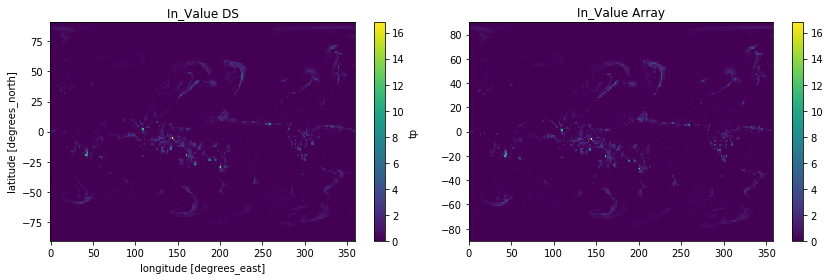

In [84]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
val.plot()
plt.title('In_Value DS')

plt.subplot(1,2,2)
plt.pcolormesh(in_lon, in_lat, tp_out_var[6, :, :])
plt.colorbar()
plt.title('In_Value Array')

plt.tight_layout()

In [85]:
# Getting the co-ordinates
out_lat = in_lat
out_lon = in_lon

In [86]:
# initiallizing the variable output sizes
out_var = np.empty((time_dim, lat_dim, lon_dim))
out_time = np.zeros((time_dim,))
out_time_bnds = np.zeros((time_dim, 2))
out_date = np.empty(out_time.shape, dtype=int)

# The very first time dimension
out_var[0, :, :] = tp_out_var[0, :, :]
out_time = np.arange(0, time_dim*6, 6)
print(out_var.shape, out_time.shape)

(7308, 121, 240) (7308,)


In [87]:
time_range = range(6, tp_time_dim, 6)
print(f"Time Dim of Output: {len(time_range)}")
print(f"Time Dim of TP var: {tp_time_dim}\nMin: {time_range[0]}, Max: {time_range[-1]}")
print(tp_out_time[time_range[-1]], tp_out_time[-1])
ind = time_range[-1]
print(tp_out_time[ind-5:ind+1])

Time Dim of Output: 7307
Time Dim of TP var: 43848
Min: 6, Max: 43842
2012-12-31 18:00:00 2012-12-31 23:00:00
[Timestamp('2012-12-31 13:00:00') Timestamp('2012-12-31 14:00:00')
 Timestamp('2012-12-31 15:00:00') Timestamp('2012-12-31 16:00:00')
 Timestamp('2012-12-31 17:00:00') Timestamp('2012-12-31 18:00:00')]


In [88]:
out_cnt = 1
for i in tqdm.notebook.tqdm(time_range, total=len(time_range)):
    out_var[out_cnt, :, :] = np.nanmean(tp_out_var[i-5:i+1, :, :], axis=0)
    out_date[out_cnt] = tp_out_date[i+1]
    out_cnt+=1
    

# getting the output time bounds
out_time_bnds[:, 1] = out_time
out_time_bnds[0, 0] = out_time[0]
out_time_bnds[1:, 0] = out_time[:-1]
    

In [89]:
# out file 
out_file = f"/localdrive/drive10/jj/mdtf/inputdata/model/ERA5.{tp_type}.{deg_type}.001/6hr/ERA5.{tp_type}.{deg_type}.001.{out_var_map[var]}.6hr.nc"
out_ds = xr.Dataset({
    'time_bnds': (('time', 'nbnd'), out_time_bnds), 
    'date': (('time'), out_date),
    out_var_map[var]: (('time', 'lat', 'lon'), out_var), 
}, 
coords={
    'time': out_time, 
    'lat': out_lat, 
    'lon': out_lon,
    'nbnd': [1, 2]
},
)

# lon attribs
out_ds.lon.attrs['long_name'] = 'longitude'
out_ds.lon.attrs['units'] = 'degrees_east'

# lat attribs
out_ds.lat.attrs['long_name'] = 'latitude'
out_ds.lat.attrs['units'] = 'degrees_north'

# time attribs
out_ds.time.attrs['long_name'] = 'time'
out_ds.time.attrs['units'] = f"hours since {year_range[0]}-01-01 00:00:00"
out_ds.time.attrs['calendar'] = calendar_type
out_ds.time.attrs['bounds'] = 'time_bnds'

# time_bnds attribs
out_ds.time_bnds.attrs['long_name'] = 'time interval endpoints'

# date attribs
out_ds.date.attrs['long_name'] = 'current date (YYYYMMDD)'

# slp attribs
out_ds[out_var_map[var]].attrs['long_name'] = out_var_long_name[var]
out_ds[out_var_map[var]].attrs['units'] = out_var_units[var]

out_ds.to_netcdf(out_file)
out_ds.close()

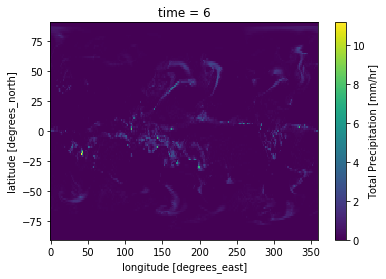

In [90]:
out_ds.PRECT.isel(time=1).plot()

# Comparing the TP vs MTPR 

In [92]:
tp_file = f'/localdrive/drive10/jj/mdtf/inputdata/model/ERA5.TP.{deg_type}.001/6hr/ERA5.TP.{deg_type}.001.PRECT.6hr.nc'
mtpr_file = f'/localdrive/drive10/jj/mdtf/inputdata/model/ERA5.MTPR.{deg_type}.001/6hr/ERA5.MTPR.{deg_type}.001.PRECT.6hr.nc'
# mtpr_file = f'/localdrive/drive10/jj/mdtf/inputdata/model/ERA5.EXP1.DEG10.001/6hr/ERA5.EXP1.{deg_type}.001.PRECT.6hr.nc'

tp = xr.open_dataset(tp_file)
mtpr = xr.open_dataset(mtpr_file)
tp.close()
mtpr.close()

In [93]:
print(tp.PRECT.shape, mtpr.PRECT.shape)

(7308, 121, 240) (7308, 121, 240)


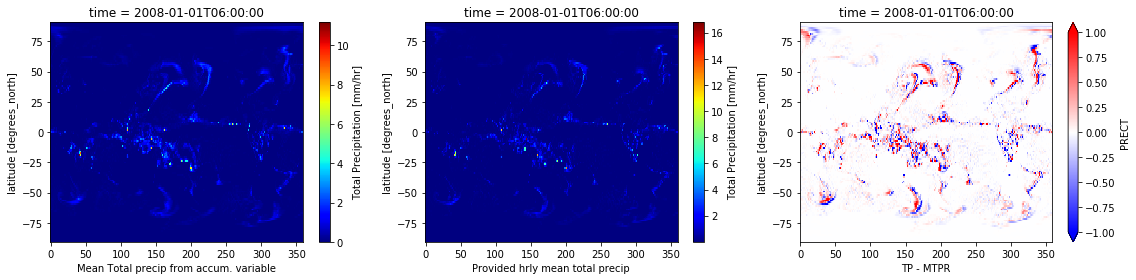

In [94]:
time_ind = 1 
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
tp.PRECT.isel(time=time_ind).plot(cmap='jet')
plt.xlabel('Mean Total precip from accum. variable')
plt.subplot(1,3,2)
mtpr.PRECT.isel(time=time_ind).plot(cmap='jet')
plt.xlabel('Provided hrly mean total precip')
plt.subplot(1,3,3)
val = tp.PRECT.isel(time=time_ind) - mtpr.PRECT.isel(time=time_ind)
vmax=1
val.plot(cmap='bwr', vmin=-vmax, vmax=vmax)
plt.xlabel('TP - MTPR')
plt.tight_layout()

Text(0.5, 1.0, 'TP - MTPR\nTime Step: 2008-01-01T06:00:00.000000000')

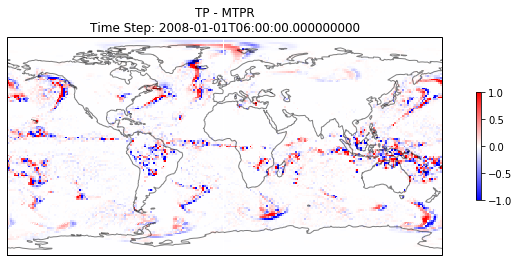

In [95]:
time_ind = 1
plt.figure(figsize=(12,4))
ax = plt.subplot(111, projection=cartopy.crs.PlateCarree())
vmax = 1
prect_diff = tp.PRECT.isel(time=time_ind) - mtpr.PRECT.isel(time=time_ind)
pc = ax.pcolormesh(tp.lon, tp.lat, prect_diff, cmap='bwr', vmin=-vmax, vmax=vmax)
ax.coastlines(alpha=0.5)
plt.colorbar(pc, ax=ax, shrink=0.5)
plt.title(f'TP - MTPR\nTime Step: {tp.time.values[time_ind]}')